### Problem statment

Tasked with creating a regression model based on Singapore Housing Dataset. This model will predict the price of a house at sale.

### Import data and library


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split , cross_val_score , cross_val_predict 
from sklearn.linear_model import LinearRegression, LassoCV , RidgeCV , ElasticNet 
from sklearn.preprocessing import StandardScaler 

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor

from statsmodels.api import qqplot


from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
import math



In [2]:
hdb_pd= pd.read_csv('./datasets/train.csv')
hdb_pd2= pd.read_csv('./datasets/train.csv')

/var/folders/9h/g66bx9554bn3vx164q9t1k3m0000gp/T/ipykernel_8223/2050515785.py:1: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  hdb_pd= pd.read_csv('./datasets/train.csv')
/var/folders/9h/g66bx9554bn3vx164q9t1k3m0000gp/T/ipykernel_8223/2050515785.py:2: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  hdb_pd2= pd.read_csv('./datasets/train.csv')


In [3]:
hdb_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150634 entries, 0 to 150633
Data columns (total 77 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         150634 non-null  int64  
 1   Tranc_YearMonth            150634 non-null  object 
 2   town                       150634 non-null  object 
 3   flat_type                  150634 non-null  object 
 4   block                      150634 non-null  object 
 5   street_name                150634 non-null  object 
 6   storey_range               150634 non-null  object 
 7   floor_area_sqm             150634 non-null  float64
 8   flat_model                 150634 non-null  object 
 9   lease_commence_date        150634 non-null  int64  
 10  resale_price               150634 non-null  float64
 11  Tranc_Year                 150634 non-null  int64  
 12  Tranc_Month                150634 non-null  int64  
 13  mid_storey                 15

In [4]:
hdb_pd.head()

,id,Tranc_YearMonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,88471,2016-05,KALLANG/WHAMPOA,4 ROOM,3B,UPP BOON KENG RD,10 TO 12,90.0,Model A,2006,...,78,1,1.317659,103.882504,1138.633422,Geylang Methodist School,224,0,1.317659,103.882504
1,122598,2012-07,BISHAN,5 ROOM,153,BISHAN ST 13,07 TO 09,130.0,Improved,1987,...,45,1,1.349783,103.854529,447.894399,Kuo Chuan Presbyterian Secondary School,232,0,1.350110,103.854892
2,170897,2013-07,BUKIT BATOK,EXECUTIVE,289B,BT BATOK ST 25,13 TO 15,144.0,Apartment,1997,...,39,0,1.345245,103.756265,180.074558,Yusof Ishak Secondary School,188,0,1.342334,103.760013
3,86070,2012-04,BISHAN,4 ROOM,232,BISHAN ST 22,01 TO 05,103.0,Model A,1992,...,20,1,1.354789,103.844934,389.515528,Catholic High School,253,1,1.354789,103.844934
4,153632,2017-12,YISHUN,4 ROOM,876,YISHUN ST 81,01 TO 03,83.0,Simplified,1987,...,74,0,1.416280,103.838798,312.025435,Orchid Park Secondary School,208,0,1.414888,103.838335


### Numeric variables

- `floor-area_sqm`:describle the floor area of the house, no missing data 
- `lease_commence_date`: no missing data, it show when the flat is build and how old is the flat
- `resale price`: thi is a price value for the house. which is an result of all the var combine together
- `town`: represent which area the flat is in singapore
- `tranc_year`: this represent the year the flat is sold
- `tranc_month`: from Jan to Dec), no missing data
- `mid_storey`, `lower`, `upper`, `mid`: this represent the storey range the house is show, it is similar to`storey_range` variable
- `floor_area_sqft`: describle the floor area of the house, no missing data, but it is same as`floor-area_sqm`
- `hdb_age`: no missing data, it represent how old is the flat since build
- `max_floor_lvl`: no missing values, it represent the max floor for this house sold
- `year_completed`: no missing values, it is similar to `hdb_age`. we can drop 1 of this variable
- `total_dwelling_units`: present total amount of unit in that blk
- `1/2/3/4/5room/exec/multigen/studio_apartment_sold/rental`: no missing values, it represent this blk consist of what type of unit
- `latitude/longitude`: no missing values,represent the blk location in GPS
- `mall_nearest_distance`: 829 missing values, can be caculate base on long/lat if this variable is used.
- `mall_within_500m/1km/2km`: count of number of malls within radius, useful aggregation and predictor variable. but there are missing data it in. might need to do data processing 
- `hawker*` variables: similar to `mall` variables, no missing data
- `mrt/bus` variables: similar to `mall` variables with the added benefit that there are no missing values
- `pri_sch/sec_sch` variables: no missing values, but distance, vacancy and afflication have different effects, may need to use all carefully. Range of variables look reasonable. Cutoff point for `sec_sch` is a good proxy for 'desirability' of the school

### data cleaning

In [5]:
#change Tranc_YearMonth to date
hdb_pd['Tranc_YearMonth'] = pd.DatetimeIndex(hdb_pd['Tranc_YearMonth'])

In [6]:
#total missing data for Mall_Nearest_distance
hdb_pd['Mall_Nearest_Distance'].isnull().sum()

829

In [7]:
#mean of Mall_Nearest_Distance
hdb_pd['Mall_Nearest_Distance'].mean()

664.2398262895447

In [8]:
#fill missing data of Mall_Nearest_distance with mean Mall_Nearest_Distance
hdb_pd['Mall_Nearest_Distance'] = hdb_pd['Mall_Nearest_Distance'].fillna(hdb_pd['Mall_Nearest_Distance'].mean())

/var/folders/9h/g66bx9554bn3vx164q9t1k3m0000gp/T/ipykernel_8223/3191017266.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels(xlable)


Text(0.5, 0, 'Reasle Price')

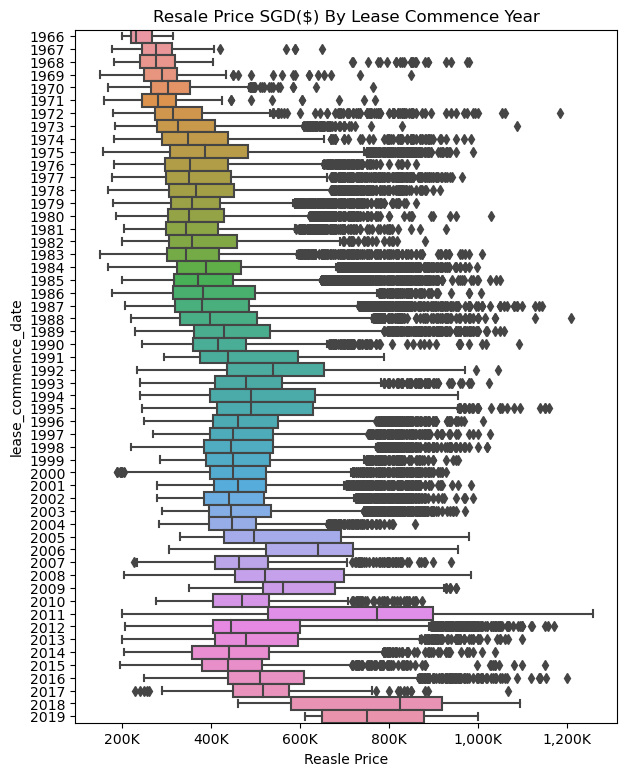

In [9]:
fig =plt.figure(figsize=(7,9))
p=sns.boxplot(y ='lease_commence_date', x='resale_price', data=hdb_pd2, width=1 , orient='h')

xlable = ['{:,.0f}'.format(x)+ 'K' for x in p.get_xticks()/1000]
p.set_xticklabels(xlable)
p.set_title('Resale Price SGD($) By Lease Commence Year')
p.set_xlabel('Reasle Price')

the younger the HDB flat, the higher the resale price.  from this we can see is linear relationship

/var/folders/9h/g66bx9554bn3vx164q9t1k3m0000gp/T/ipykernel_8223/1504993814.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels(xlable)


Text(0.5, 0, 'Reasle Price')

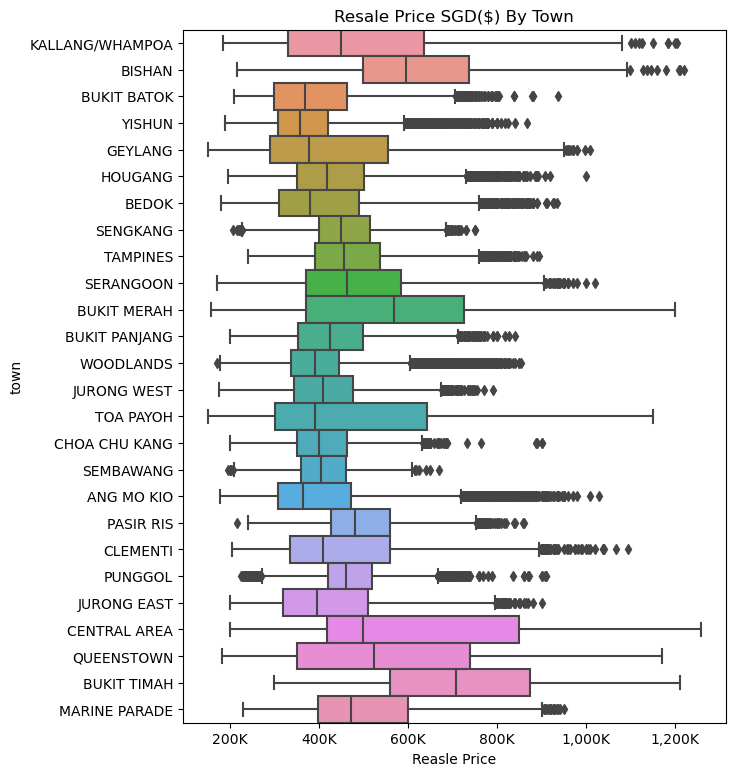

In [10]:
fig =plt.figure(figsize=(7,9))
p=sns.boxplot(y ='town', x='resale_price', data=hdb_pd2, width=1 , orient='h')

xlable = ['{:,.0f}'.format(x)+ 'K' for x in p.get_xticks()/1000]
p.set_xticklabels(xlable)
p.set_title('Resale Price SGD($) By Town')
p.set_xlabel('Reasle Price')

from this box plot we can tell the central area, queentown and bukit timah have a higher resale price

/var/folders/9h/g66bx9554bn3vx164q9t1k3m0000gp/T/ipykernel_8223/1629457562.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels(xlable)


Text(0.5, 0, 'Reasle Price')

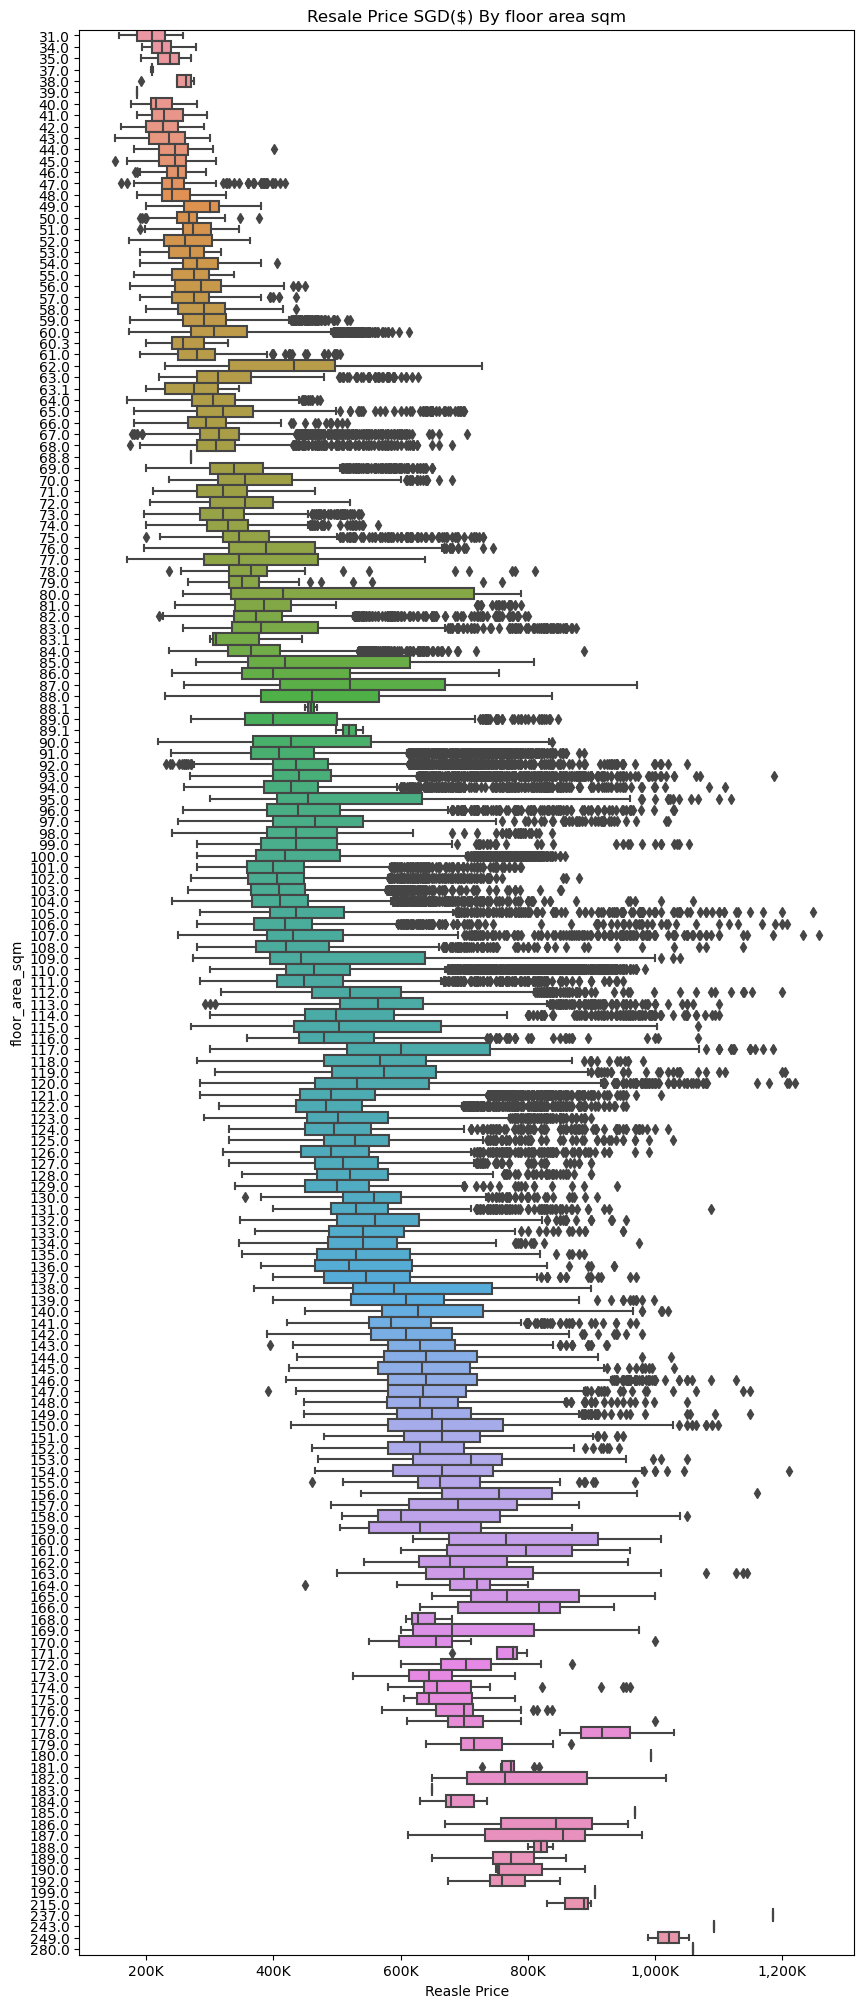

In [11]:
fig =plt.figure(figsize=(10,25))
p=sns.boxplot(y ='floor_area_sqm', x='resale_price', data=hdb_pd2, width=1 , orient='h')

xlable = ['{:,.0f}'.format(x)+ 'K' for x in p.get_xticks()/1000]
p.set_xticklabels(xlable)
p.set_title('Resale Price SGD($) By floor area sqm')
p.set_xlabel('Reasle Price')

the higher the floor are sqm , the higher the resale price.  from this we can see is linear relationship

/var/folders/9h/g66bx9554bn3vx164q9t1k3m0000gp/T/ipykernel_8223/1206167759.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels(xlable)


Text(0.5, 0, 'Reasle Price')

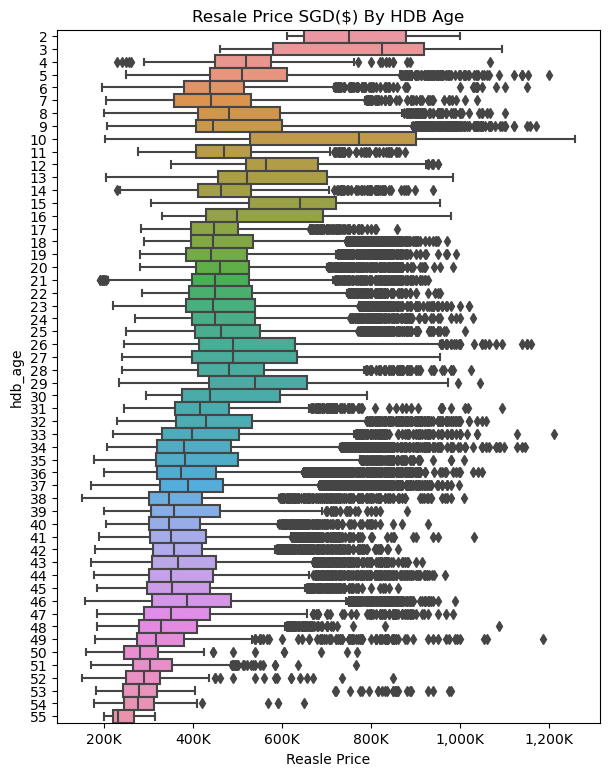

In [105]:
fig =plt.figure(figsize=(7,9))
p=sns.boxplot(y ='hdb_age', x='resale_price', data=hdb_pd2, width=1 , orient='h')

xlable = ['{:,.0f}'.format(x)+ 'K' for x in p.get_xticks()/1000]
p.set_xticklabels(xlable)
p.set_title('Resale Price SGD($) By HDB Age')
p.set_xlabel('Reasle Price')

it is same as lease commence year. therefore we will drop one of them for model prediction.

/var/folders/9h/g66bx9554bn3vx164q9t1k3m0000gp/T/ipykernel_8223/3688707208.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels(xlable)


Text(0.5, 0, 'Reasle Price')

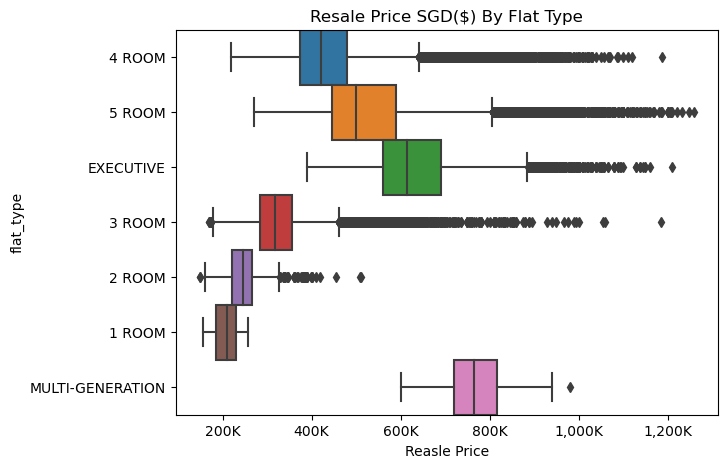

In [13]:
fig =plt.figure(figsize=(7,5))
p=sns.boxplot(y ='flat_type', x='resale_price', data=hdb_pd2, width=1 , orient='h')

xlable = ['{:,.0f}'.format(x)+ 'K' for x in p.get_xticks()/1000]
p.set_xticklabels(xlable)
p.set_title('Resale Price SGD($) By Flat Type')
p.set_xlabel('Reasle Price')

/var/folders/9h/g66bx9554bn3vx164q9t1k3m0000gp/T/ipykernel_8223/1152892454.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels(xlable)


Text(0.5, 0, 'Reasle Price')

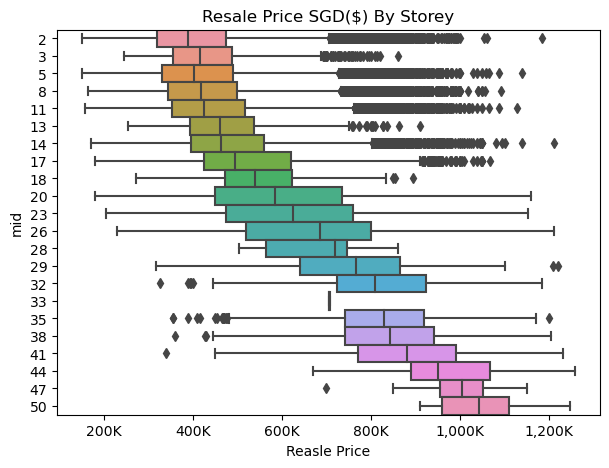

In [104]:
fig =plt.figure(figsize=(7,5))
p=sns.boxplot(y ='mid', x='resale_price', data=hdb_pd2, width=1 , orient='h')

xlable = ['{:,.0f}'.format(x)+ 'K' for x in p.get_xticks()/1000]
p.set_xticklabels(xlable)
p.set_title('Resale Price SGD($) By Storey')
p.set_xlabel('Reasle Price')

the higher the storey, the higher the reasle price are. from this we can see is linear relationship

### remove columns to simplify model to prevent over fitting for gerenal use
check for corelation for variable

In [14]:
hdb_corra_ascending=hdb_pd.corr()[['resale_price']].sort_values(by='resale_price',ascending=True)

/var/folders/9h/g66bx9554bn3vx164q9t1k3m0000gp/T/ipykernel_8223/1956151452.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  hdb_corra_ascending=hdb_pd.corr()[['resale_price']].sort_values(by='resale_price',ascending=True)


In [15]:
hdb_corra_ascending

,resale_price
3room_sold,-0.410368
hdb_age,-0.350337
sec_sch_latitude,-0.216303
Latitude,-0.216153
bus_stop_latitude,-0.215760
mrt_latitude,-0.214939
pri_sch_latitude,-0.214707
2room_sold,-0.145287
total_dwelling_units,-0.140725
mrt_nearest_distance,-0.128222


In [16]:
hdb_corra_decending=hdb_pd.corr()[['resale_price']].sort_values(by='resale_price',ascending=False)

/var/folders/9h/g66bx9554bn3vx164q9t1k3m0000gp/T/ipykernel_8223/2264001683.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  hdb_corra_decending=hdb_pd.corr()[['resale_price']].sort_values(by='resale_price',ascending=False)


In [17]:
hdb_corra_decending

,resale_price
resale_price,1.000000
floor_area_sqm,0.654120
floor_area_sqft,0.654120
id,0.521504
max_floor_lvl,0.495650
5room_sold,0.359434
year_completed,0.353698
upper,0.353552
mid_storey,0.353213
mid,0.353213


remove id as it if form of number for the transcation, it does not effect the modeling

remove floor_area_sqm as it is same as floor_area_sqft

remove hdb age and year completed as it is same as lease commence date

remove room_sold as it does not affect the model prediction as we are trying to predict resale price

remove mid_storey, lower , upper , mid. we will be using mid storey instead

we will remove school primary school and secondary school: name, lat and long and cutoff point, will instead use distance to primary and sec school

In [18]:
hdb_pd.drop(columns=['id','floor_area_sqm','cutoff_point','multistorey_carpark','precinct_pavilion','block','street_name','lower','upper','mid','lower','upper','mid','address','residential','commercial','market_hawker','total_dwelling_units','1room_sold','2room_sold','3room_sold','5room_sold','4room_sold','exec_sold','multigen_sold','studio_apartment_sold','1room_rental','2room_rental','3room_rental','other_room_rental','postal','Latitude','Longitude','planning_area','Mall_Within_500m','Mall_Within_1km','Mall_Within_2km','Hawker_Within_500m','Hawker_Within_1km','Hawker_Within_2km','hawker_food_stalls','hawker_market_stalls','mrt_name','bus_interchange','mrt_interchange','mrt_latitude','mrt_longitude','bus_stop_name','bus_stop_latitude','bus_stop_longitude','pri_sch_name','vacancy','pri_sch_affiliation','pri_sch_latitude','pri_sch_longitude','sec_sch_name','affiliation','sec_sch_latitude','sec_sch_longitude','hdb_age','year_completed'], inplace=True)

In [19]:
#fig = plt.figure(figsize=(10,10))
#ax = sns.heatmap(hdb_pd.select_dtypes(include=['int64','float64']).corr(), annot = True, fmt='.2g',
#    vmin=-1, vmax=1, center= 0, cmap= 'coolwarm_r',linecolor='black', linewidth=1, annot_kws={"size": 7})
#ax.set_ylim(0 ,5)
#plt.xticks(rotation=45, ha='right')
#plt.title('Correlation Heatmap')
#fig.show()



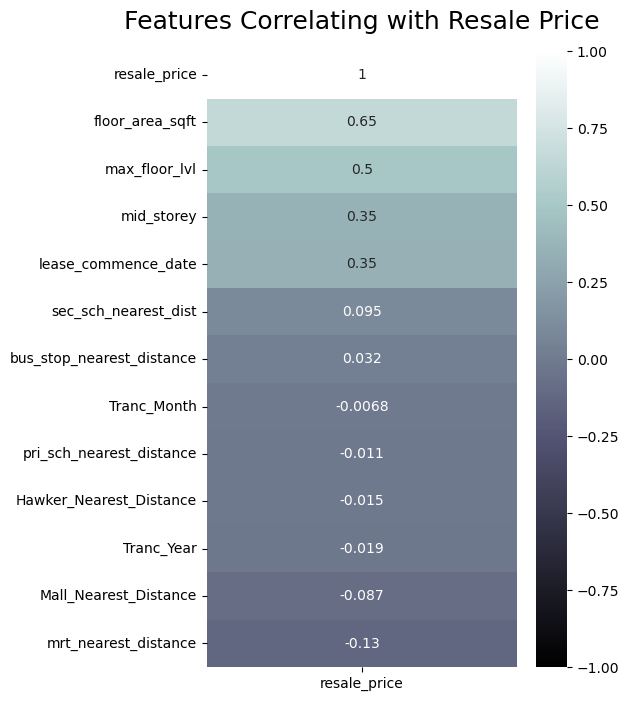

In [20]:
plt.figure(figsize=(5, 8))
heatmap = sns.heatmap(hdb_pd.corr(method='pearson',numeric_only=True)[['resale_price']].sort_values(by='resale_price', ascending=False), 
                      vmin=-1, vmax=1, annot=True, cmap='bone')
heatmap.set_title('Features Correlating with Resale Price', fontdict={'fontsize':18}, pad=16);

In [21]:
hdb_pd.drop(columns=['Tranc_Month','Tranc_Year'], inplace=True)

variable to keep with correlation more than 0.1
and keep all the distance to amenities

In [22]:
hdb_pd.columns

Index(['Tranc_YearMonth', 'town', 'flat_type', 'storey_range', 'flat_model',
       'lease_commence_date', 'resale_price', 'mid_storey', 'full_flat_type',
       'floor_area_sqft', 'max_floor_lvl', 'Mall_Nearest_Distance',
       'Hawker_Nearest_Distance', 'mrt_nearest_distance',
       'bus_stop_nearest_distance', 'pri_sch_nearest_distance',
       'sec_sch_nearest_dist'],
      dtype='object')

In [23]:
for i in list(hdb_pd.select_dtypes(include='object').columns):
    print(i,len(set(hdb_pd[i].values)))

town 26
flat_type 7
storey_range 25
flat_model 20
full_flat_type 43


In [24]:
hdb_pd['town'].value_counts()

JURONG WEST        11451
WOODLANDS          11334
SENGKANG           11069
TAMPINES           10506
YISHUN             10042
BEDOK               9046
PUNGGOL             7793
HOUGANG             7555
ANG MO KIO          6908
CHOA CHU KANG       6343
BUKIT MERAH         5854
BUKIT PANJANG       5686
BUKIT BATOK         5623
TOA PAYOH           4817
PASIR RIS           4763
KALLANG/WHAMPOA     4340
QUEENSTOWN          4121
GEYLANG             3986
SEMBAWANG           3723
CLEMENTI            3633
JURONG EAST         3470
SERANGOON           3123
BISHAN              2871
CENTRAL AREA        1249
MARINE PARADE        959
BUKIT TIMAH          369
Name: town, dtype: int64

<AxesSubplot: >

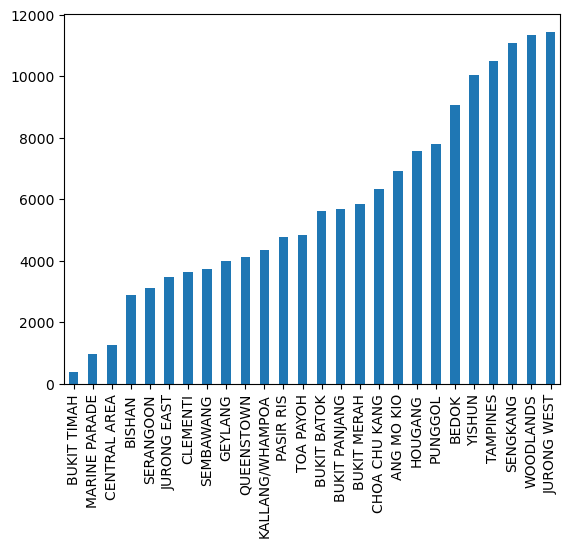

In [25]:
hdb_pd['town'].value_counts(ascending=True).plot(kind='bar')

In [26]:
#plt.figure(figsize=(20,10))
#plt.hist(hdb_pd['town'], bins=60)
#plt.xticks(rotation=30 , ha='right')
#plt.title('Town', fontsize= 30)
#plt.ylabel('count', fontsize=20)

In [27]:
hdb_pd['flat_type'].value_counts()

4 ROOM              61136
3 ROOM              39060
5 ROOM              36415
EXECUTIVE           11989
2 ROOM               1896
1 ROOM                 82
MULTI-GENERATION       56
Name: flat_type, dtype: int64

<AxesSubplot: >

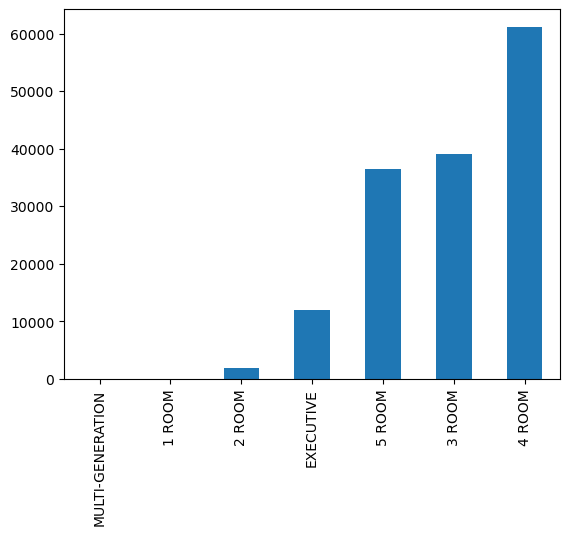

In [28]:
hdb_pd['flat_type'].value_counts(ascending=True).plot(kind='bar')

In [29]:
#plt.figure(figsize=(8,8))
#plt.hist(hdb_pd['flat_type'],bins=50)
#plt.title('Different flat type', fontsize= 20)
#plt.xlabel('type of flat')
#plt.ylabel('count', fontsize=15)
#plt.xticks(rotation=10 , ha='right')

<AxesSubplot: >

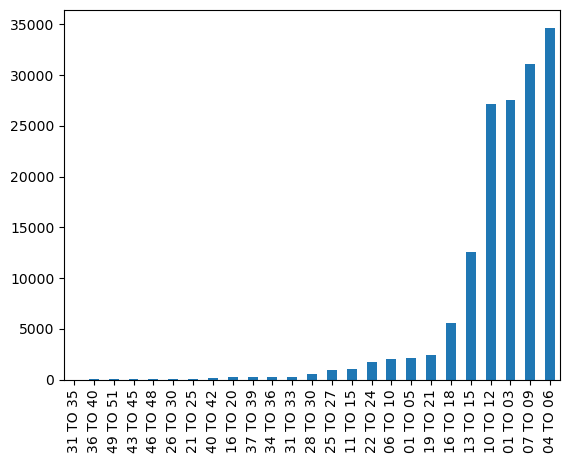

In [30]:
hdb_pd['storey_range'].value_counts(ascending=True).plot(kind='bar')

In [31]:
#plt.figure(figsize=(20,10))
#plt.hist(hdb_pd['storey_range'],bins=50)
#plt.xticks(rotation=10 , ha='right')
#plt.title('storey range', fontsize = 25)
#plt.ylabel('count', fontsize=25)

<AxesSubplot: >

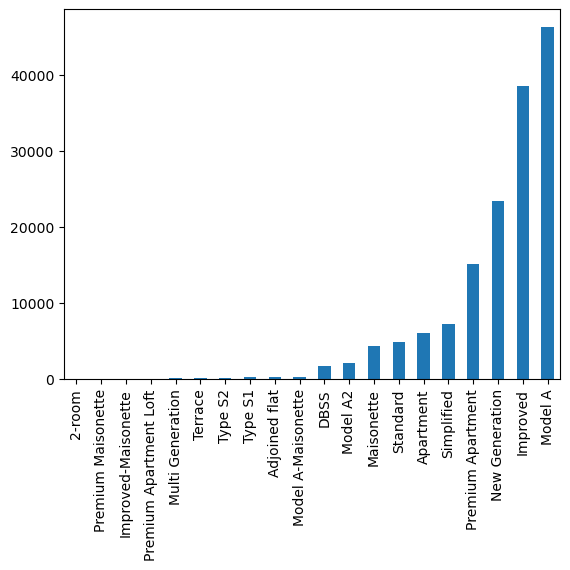

In [32]:
hdb_pd['flat_model'].value_counts(ascending=True).plot(kind='bar')

In [33]:
#plt.figure(figsize=(20,10))
#plt.hist(hdb_pd['flat_model'],bins=50)
#plt.xticks(rotation=10 , ha='right')

<AxesSubplot: >

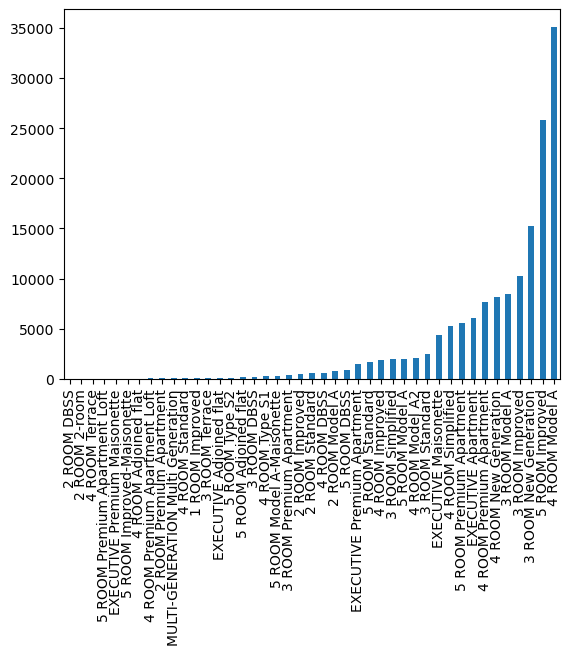

In [34]:
hdb_pd['full_flat_type'].value_counts(ascending=True).plot(kind='bar')

In [35]:
hdb_pd.isnull().sum()

Tranc_YearMonth              0
town                         0
flat_type                    0
storey_range                 0
flat_model                   0
lease_commence_date          0
resale_price                 0
mid_storey                   0
full_flat_type               0
floor_area_sqft              0
max_floor_lvl                0
Mall_Nearest_Distance        0
Hawker_Nearest_Distance      0
mrt_nearest_distance         0
bus_stop_nearest_distance    0
pri_sch_nearest_distance     0
sec_sch_nearest_dist         0
dtype: int64

array([[<AxesSubplot: title={'center': 'Tranc_YearMonth'}>,
        <AxesSubplot: title={'center': 'lease_commence_date'}>,
        <AxesSubplot: title={'center': 'resale_price'}>],
       [<AxesSubplot: title={'center': 'mid_storey'}>,
        <AxesSubplot: title={'center': 'floor_area_sqft'}>,
        <AxesSubplot: title={'center': 'max_floor_lvl'}>],
       [<AxesSubplot: title={'center': 'Mall_Nearest_Distance'}>,
        <AxesSubplot: title={'center': 'Hawker_Nearest_Distance'}>,
        <AxesSubplot: title={'center': 'mrt_nearest_distance'}>],
       [<AxesSubplot: title={'center': 'bus_stop_nearest_distance'}>,
        <AxesSubplot: title={'center': 'pri_sch_nearest_distance'}>,
        <AxesSubplot: title={'center': 'sec_sch_nearest_dist'}>]],
      dtype=object)

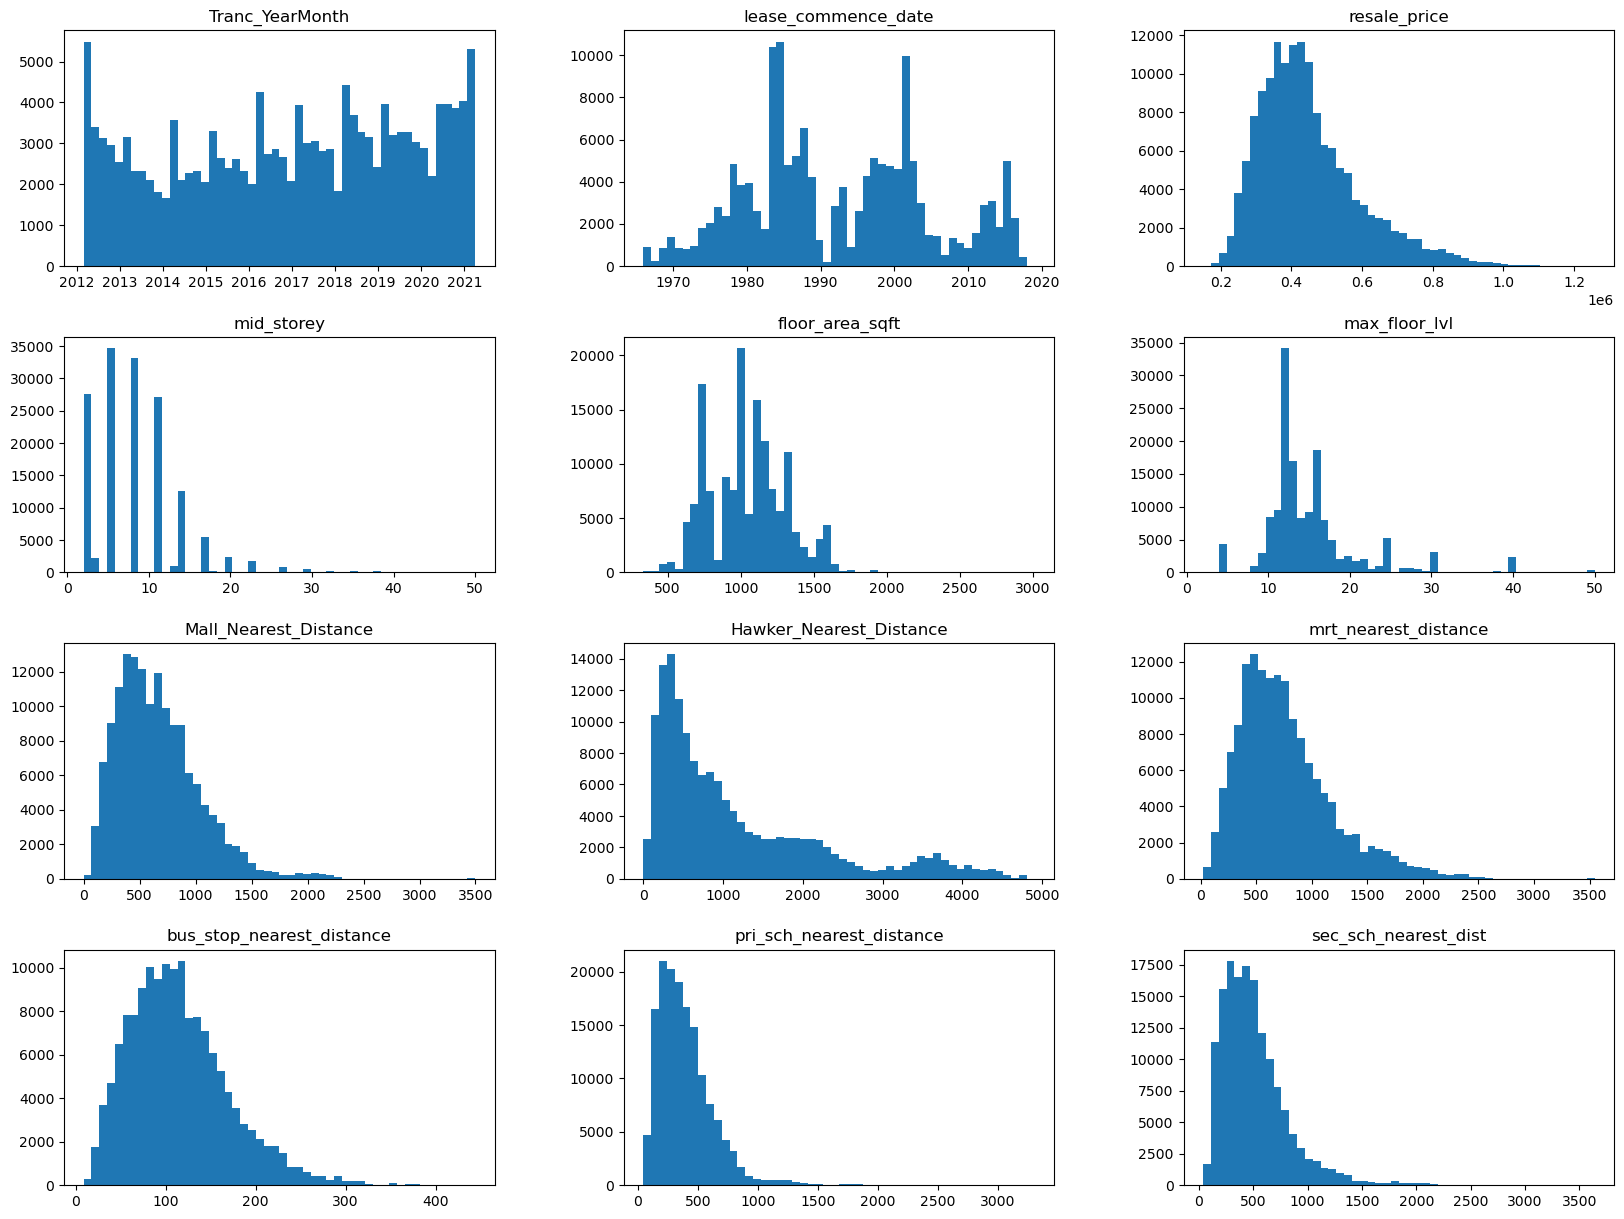

In [36]:
hdb_pd.hist(bins=50, figsize=(20,15), grid=False)

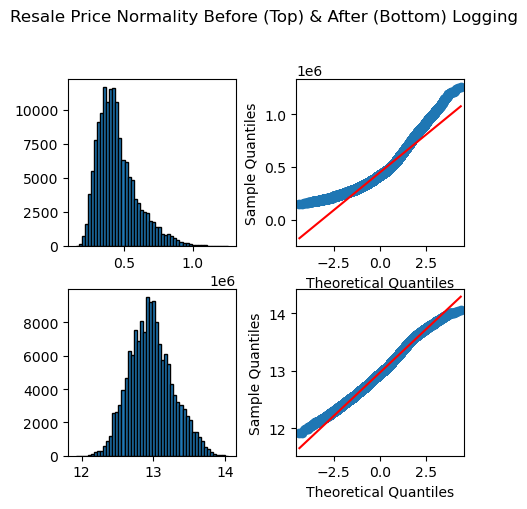

In [37]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize=(5,5))

ax1.hist(hdb_pd['resale_price'], bins=50, edgecolor='black')
qqplot(hdb_pd['resale_price'], line='s', ax=ax2)
ax3.hist(np.log(hdb_pd['resale_price']), bins=50, edgecolor='black')
qqplot(np.log(hdb_pd['resale_price']), line='s', ax=ax4)
plt.suptitle('Resale Price Normality Before (Top) & After (Bottom) Logging')
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.show()

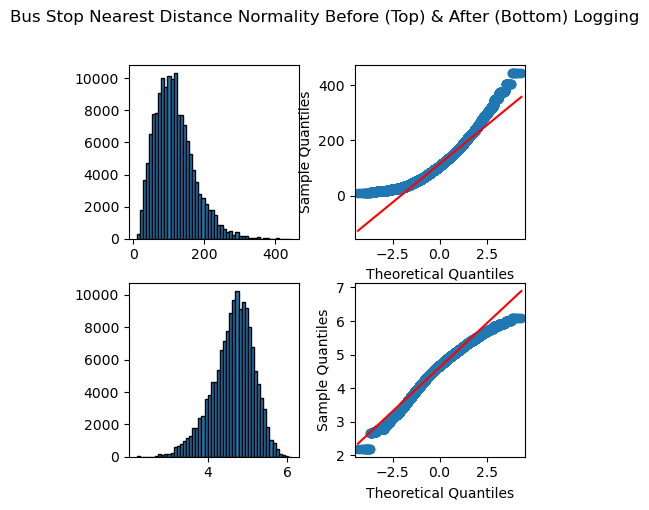

In [38]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize=(5,5))

ax1.hist(hdb_pd['bus_stop_nearest_distance'], bins=50, edgecolor='black')
qqplot(hdb_pd['bus_stop_nearest_distance'], line='s', ax=ax2)
ax3.hist(np.log(hdb_pd['bus_stop_nearest_distance']), bins=50, edgecolor='black')
qqplot(np.log(hdb_pd['bus_stop_nearest_distance']), line='s', ax=ax4)
plt.suptitle('Bus Stop Nearest Distance Normality Before (Top) & After (Bottom) Logging')
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.show()

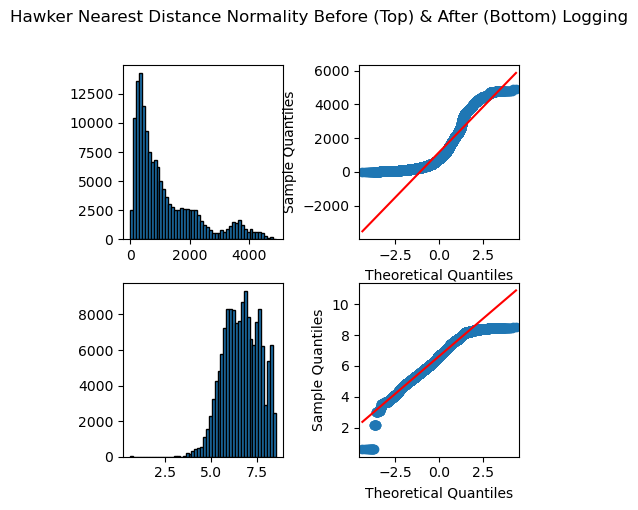

In [39]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize=(5,5))

ax1.hist(hdb_pd['Hawker_Nearest_Distance'], bins=50, edgecolor='black')
qqplot(hdb_pd['Hawker_Nearest_Distance'], line='s', ax=ax2)
ax3.hist(np.log(hdb_pd['Hawker_Nearest_Distance']), bins=50, edgecolor='black')
qqplot(np.log(hdb_pd['Hawker_Nearest_Distance']), line='s', ax=ax4)
plt.suptitle('Hawker Nearest Distance Normality Before (Top) & After (Bottom) Logging')
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.show()

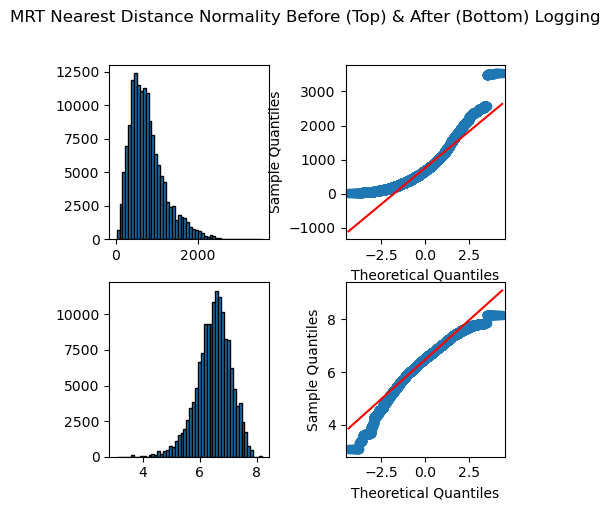

In [40]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize=(5,5))

ax1.hist(hdb_pd['mrt_nearest_distance'], bins=50, edgecolor='black')
qqplot(hdb_pd['mrt_nearest_distance'], line='s', ax=ax2)
ax3.hist(np.log(hdb_pd['mrt_nearest_distance']), bins=50, edgecolor='black')
qqplot(np.log(hdb_pd['mrt_nearest_distance']), line='s', ax=ax4)
plt.suptitle('MRT Nearest Distance Normality Before (Top) & After (Bottom) Logging')
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.show()

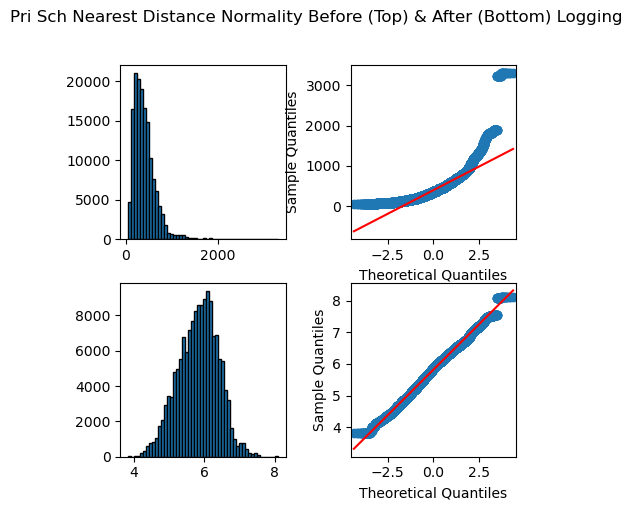

In [41]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize=(5,5))

ax1.hist(hdb_pd['pri_sch_nearest_distance'], bins=50, edgecolor='black')
qqplot(hdb_pd['pri_sch_nearest_distance'], line='s', ax=ax2)
ax3.hist(np.log(hdb_pd['pri_sch_nearest_distance']), bins=50, edgecolor='black')
qqplot(np.log(hdb_pd['pri_sch_nearest_distance']), line='s', ax=ax4)
plt.suptitle('Pri Sch Nearest Distance Normality Before (Top) & After (Bottom) Logging')
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.show()

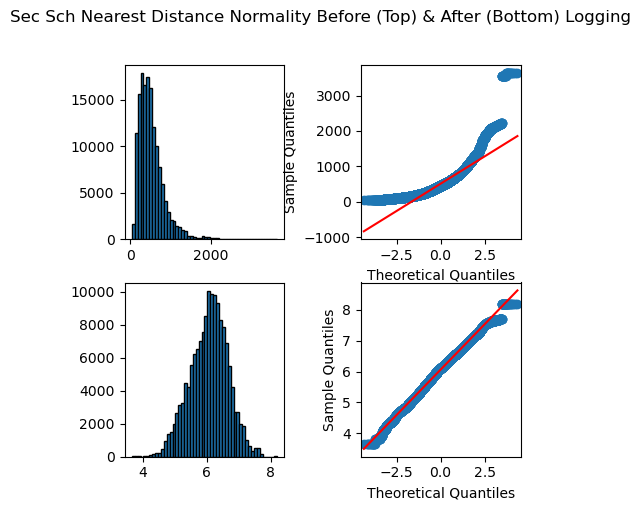

In [42]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize=(5,5))

ax1.hist(hdb_pd['sec_sch_nearest_dist'], bins=50, edgecolor='black')
qqplot(hdb_pd['sec_sch_nearest_dist'], line='s', ax=ax2)
ax3.hist(np.log(hdb_pd['sec_sch_nearest_dist']), bins=50, edgecolor='black')
qqplot(np.log(hdb_pd['sec_sch_nearest_dist']), line='s', ax=ax4)
plt.suptitle('Sec Sch Nearest Distance Normality Before (Top) & After (Bottom) Logging')
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.show()

In [43]:
scaler = StandardScaler()

# fit to continuous columns and transform
scaled_columns = ['floor_area_sqft','lease_commence_date','Hawker_Nearest_Distance',
                  'Mall_Nearest_Distance','mrt_nearest_distance','bus_stop_nearest_distance',
                  'pri_sch_nearest_distance','sec_sch_nearest_dist' ]
                 
scaler.fit(hdb_pd[scaled_columns])
scaled_columns = pd.DataFrame(scaler.transform(hdb_pd[scaled_columns]), index=hdb_pd.index, columns=scaled_columns)

# separate unscaled features
unscaled_columns = hdb_pd.drop(scaled_columns, axis=1)

# concatenate scaled and unscaled features
hdb_pd = pd.concat([scaled_columns,unscaled_columns], axis=1)
hdb_pd

,floor_area_sqft,lease_commence_date,Hawker_Nearest_Distance,Mall_Nearest_Distance,mrt_nearest_distance,bus_stop_nearest_distance,pri_sch_nearest_distance,sec_sch_nearest_dist,Tranc_YearMonth,town,flat_type,storey_range,flat_model,resale_price,mid_storey,full_flat_type,max_floor_lvl
0,-0.294949,1.116383,-0.946363,1.168956,-1.012950,-1.544492,3.166894,2.038729,2016-05-01,KALLANG/WHAMPOA,4 ROOM,10 TO 12,Model A,680000.0,11,4 ROOM Model A,25
1,1.344196,-0.448847,-0.495541,0.551236,0.322923,-1.026605,0.087044,-0.196201,2012-07-01,BISHAN,5 ROOM,07 TO 09,Improved,665000.0,8,5 ROOM Improved,9
2,1.917897,0.374958,0.546469,2.162885,1.325781,1.790249,0.441625,-1.062749,2013-07-01,BUKIT BATOK,EXECUTIVE,13 TO 15,Apartment,838000.0,14,EXECUTIVE Apartment,16
3,0.237773,-0.036945,-0.415609,0.777586,0.331759,-1.293126,-0.024099,-0.385089,2012-04-01,BISHAN,4 ROOM,01 TO 05,Model A,550000.0,3,4 ROOM Model A,11
4,-0.581800,-0.448847,0.340347,0.178211,-0.821364,0.254870,0.025676,-0.635813,2017-12-01,YISHUN,4 ROOM,01 TO 03,Simplified,298000.0,2,4 ROOM Simplified,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150629,2.614534,0.210197,-0.185729,-0.215111,-0.119553,0.401409,0.101427,-1.030991,2020-09-01,WOODLANDS,EXECUTIVE,04 TO 06,Apartment,625000.0,5,EXECUTIVE Apartment,12
150630,0.524624,0.704480,0.588902,-1.126273,-1.223283,-1.068137,-1.102721,0.342598,2017-06-01,JURONG WEST,5 ROOM,04 TO 06,Improved,455000.0,5,5 ROOM Improved,16
150631,1.917897,0.045436,-0.090499,3.061590,-0.222943,0.506178,0.500314,0.156461,2020-12-01,BEDOK,EXECUTIVE,10 TO 12,Apartment,733000.0,11,EXECUTIVE Apartment,15
150632,-1.565287,-1.519795,-0.794234,-0.209384,-0.612480,2.355707,1.670122,1.047848,2016-05-01,QUEENSTOWN,3 ROOM,07 TO 09,Improved,338000.0,8,3 ROOM Improved,10


we will be using flat_type to create dummies as it best show the distruibuting of the flat type

In [44]:
create_dummy = pd.get_dummies(hdb_pd[['town','flat_type']],drop_first=True)

In [45]:
create_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150634 entries, 0 to 150633
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype
---  ------                      --------------   -----
 0   town_BEDOK                  150634 non-null  uint8
 1   town_BISHAN                 150634 non-null  uint8
 2   town_BUKIT BATOK            150634 non-null  uint8
 3   town_BUKIT MERAH            150634 non-null  uint8
 4   town_BUKIT PANJANG          150634 non-null  uint8
 5   town_BUKIT TIMAH            150634 non-null  uint8
 6   town_CENTRAL AREA           150634 non-null  uint8
 7   town_CHOA CHU KANG          150634 non-null  uint8
 8   town_CLEMENTI               150634 non-null  uint8
 9   town_GEYLANG                150634 non-null  uint8
 10  town_HOUGANG                150634 non-null  uint8
 11  town_JURONG EAST            150634 non-null  uint8
 12  town_JURONG WEST            150634 non-null  uint8
 13  town_KALLANG/WHAMPOA        150634 non-null 

In [46]:
hdb_pd.drop(columns=['town','flat_type','storey_range','flat_model','full_flat_type','Tranc_YearMonth'], inplace=True)

### merge dummy and file

In [47]:
hdb_final=pd.merge(hdb_pd,create_dummy, how='left', left_index=True, right_index=True)

In [48]:
hdb_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150634 entries, 0 to 150633
Data columns (total 42 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   floor_area_sqft             150634 non-null  float64
 1   lease_commence_date         150634 non-null  float64
 2   Hawker_Nearest_Distance     150634 non-null  float64
 3   Mall_Nearest_Distance       150634 non-null  float64
 4   mrt_nearest_distance        150634 non-null  float64
 5   bus_stop_nearest_distance   150634 non-null  float64
 6   pri_sch_nearest_distance    150634 non-null  float64
 7   sec_sch_nearest_dist        150634 non-null  float64
 8   resale_price                150634 non-null  float64
 9   mid_storey                  150634 non-null  int64  
 10  max_floor_lvl               150634 non-null  int64  
 11  town_BEDOK                  150634 non-null  uint8  
 12  town_BISHAN                 150634 non-null  uint8  
 13  town_BUKIT BAT

In [49]:
hdb_final.to_csv('./datasets/hdb_final_data.csv')

### Train Test Split

from above chart we can see the resale price is log compare to highest corelation area. therefor we will log the reslae price for model training

In [50]:
# set X and y for train test split
y = np.log(hdb_final['resale_price'])
X = hdb_final.drop(columns=['resale_price'])

In [51]:
lr=LinearRegression()
X_train,X_test,y_train,y_test =train_test_split(X,y,random_state=30)

### BASE MODEL Linear Model

In [52]:
def test_metric(model, X_train, X_test, y_train, y_test, metric='r2_score', cv=5, modifier='linear'):
    """
    Function to return specified test metric for train, validation and test sets
    
    Parameters
    ----------
       
    model: sklearn model
        model to run predictions on
    
    X_train: pandas Dataframe
        training predictor dataset
    
    X_test: pandas Dataframe
        test predictor dataset
        
    y_train: pandas Series/Dataframe
        training outcome dataset
        
    y_test: pandas Series/Dataframe
        test outcome dataset

    metric: str
        'r2_score' - evaluates R2 score (default)
        'rmse' - evaluates root mean squared error
        'rmape' - evaluates root mean absolute percentage error
        
    cv: int
        number of cross validation folds (default = 5)
        
    modifier: str
        'linear' - y is resale price with no modification
        'log' - y is np.log(resale price))
        
    Returns
    -------
    Prints out metric in 3 lines
    
    """
    
    # import libraries
    from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
    import numpy as np
    
    if modifier == 'linear':
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
    elif modifier == 'log':
        y_pred_train = np.exp(model.predict(X_train))
        y_pred_test = np.exp(model.predict(X_test))
        y_train = np.exp(y_train)
        y_test = np.exp(y_test)
    
    # select function to use
    if metric == 'r2_score':
        train_metric = r2_score(y_train, y_pred_train)
        cross_metric = cross_val_score(model, X_train, y_train, cv=cv).mean()
        test_metric = r2_score(y_test, y_pred_test)
    elif metric == 'rmse':
        train_metric = mean_squared_error(y_train, y_pred_train, squared=False)
        cross_metric = -1 * cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
        test_metric = mean_squared_error(y_test, y_pred_test, squared=False)
    elif metric == 'rmape':
        train_metric = mean_absolute_percentage_error(y_train, y_pred_train)
        cross_metric = -1 * cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_percentage_error').mean()
        test_metric = mean_absolute_percentage_error(y_test, y_pred_test)
    else:
        print('ERROR: Invalid metric chosen')
        return
        
    print(f'Train {metric.upper()}:           \t{train_metric:.4f}')
    print(f'{cv}-Fold CV {metric.upper()}:     \t{cross_metric:.4f}')
    print(f'Test {metric.upper()}:            \t{test_metric:.4f}')

In [53]:
base_model = DummyRegressor(strategy='median')

base_model.fit(X_train, y_train)

DummyRegressor(strategy='median')

In [54]:
test_metric(base_model, X_train, X_test, y_train, y_test, metric='rmse', modifier='log')

Train RMSE:           	146346.2397
5-Fold CV RMSE:     	146307.7856
Test RMSE:            	145936.9910


In [55]:
lr=lr.fit(X_train,y_train)

In [56]:
lr.score(X_train,y_train)

0.8669110670267133

In [57]:
test_metric(lr, X_train, X_test, y_train, y_test, metric='rmse', modifier='log')

Train RMSE:           	49412.9620
5-Fold CV RMSE:     	55018.4940
Test RMSE:            	49468.5079


In [58]:
lr.coef_

array([ 0.18486225,  0.09673627, -0.03911244, -0.01419351, -0.05340679,
        0.00059785,  0.00434558,  0.0072543 ,  0.00669778,  0.00431106,
       -0.04437067,  0.16143369, -0.12144512,  0.12918847, -0.23498637,
        0.23579798,  0.12373801, -0.24788053,  0.05789743, -0.00393174,
       -0.11580627, -0.11084369, -0.21986665,  0.04437109,  0.41040343,
       -0.14080796, -0.07335202,  0.11370993, -0.31988426, -0.15296122,
        0.05786641, -0.06228526,  0.02008604, -0.32269412, -0.18829478,
        0.0202896 ,  0.18218805,  0.25209962,  0.26796125,  0.32477677,
        0.39314562])

In [59]:
lr.score(X_test,y_test)

0.8667373831304075

In [60]:
cross_val_score(lr, X_train,y_train,cv=5)

array([0.86705173, 0.86802533, 0.86436833, 0.86830158, 0.86592408])

In [61]:
y_pred = lr.predict(X_train)
y_pred

array([12.56057546, 12.65525406, 12.49973074, ..., 12.65915575,
       12.72786076, 12.69442647])

In [62]:
RSME = mean_squared_error(np.exp(y_train),np.exp(y_pred))
RSME = math.sqrt(RSME)
RSME

49412.962038036916

In [63]:
print(mean_absolute_percentage_error(np.exp(y_train),np.exp(y_pred)))

0.08617135895654275


In [64]:
r2_score(np.exp(y_train),np.exp(y_pred))

0.8812374427074265

In [65]:
price = {'resale_price': np.exp(list(y_train)),'predicted_resale_price': np.exp(list(y_pred))}
result= pd.DataFrame(price)
result

,resale_price,predicted_resale_price
0,320000.0,285094.351305
1,235000.0,313405.781927
2,258000.0,268265.043214
3,680000.0,622040.071892
4,870000.0,791786.923695
...,...,...
112970,305000.0,266735.920276
112971,320000.0,331418.525622
112972,318000.0,314630.983008
112973,360000.0,337007.600945


In [66]:
result['difference_from_orginal_in_%']= (result['predicted_resale_price']-result['resale_price'])/result['resale_price']*100

In [67]:
result_20_difference = result[(result['difference_from_orginal_in_%']>10) | (result['difference_from_orginal_in_%']<-10)]
result_20_difference

,resale_price,predicted_resale_price,difference_from_orginal_in_%
0,320000.0,285094.351305,-10.908015
1,235000.0,313405.781927,33.364163
5,440000.0,499941.318545,13.623027
10,320000.0,286176.670908,-10.569790
13,768000.0,685841.976709,-10.697659
...,...,...,...
112958,420000.0,462778.279864,10.185305
112961,363000.0,317917.611207,-12.419391
112963,425000.0,472359.464190,11.143403
112964,236000.0,273449.896697,15.868600


### Compare Actual Resale Pirce with predicted from lasso, ridge , ElasticNet

In [68]:
#lasso model
lasso = LassoCV(n_alphas=200)

In [69]:
#ridge model
ridge = RidgeCV(alphas=np.linspace(.1,10,100))

In [70]:
#fit linear model
lr=lr.fit(X_train,y_train)
list_lr_coef=list(lr.coef_)

In [71]:
compare_lr_coef_variable = {'feature': list(X_train.columns[0:]),'coef':list_lr_coef}
compare_lr_coef_variable= pd.DataFrame(compare_lr_coef_variable)

In [72]:
lasso=lasso.fit(X_train,y_train)
list_lasso_coef=list(lasso.coef_)
lasso.coef_

array([ 0.21897408,  0.07778372, -0.06523551, -0.00921331, -0.05643176,
        0.00108096,  0.00390068,  0.01365566,  0.00676466,  0.00786385,
       -0.00778654,  0.16018919, -0.02661374,  0.10937538, -0.14992647,
        0.        ,  0.        , -0.10590837,  0.04584541,  0.        ,
       -0.0371092 , -0.05352643, -0.14023156,  0.01837782,  0.28157636,
       -0.05030947,  0.07113236,  0.0768828 , -0.17663317, -0.02926397,
        0.08412555, -0.        ,  0.        , -0.24685973, -0.11262325,
       -0.05271946, -0.        ,  0.01801606, -0.        ,  0.00799861,
        0.        ])

most feature coef has been reduce to 0, we will compare later

In [73]:
compare_lasso_coef_variable = {'feature': list(X_train.columns[0:]),'coef':list_lasso_coef}
compare_lasso_coef_variable= pd.DataFrame(compare_lasso_coef_variable)

In [74]:
#lasso score
lasso_scores = cross_val_score(lasso, X_test, y_test, cv=5)
lasso_scores.mean()

0.8502174522771725

In [75]:
#lasso RSME
test_metric(lasso, X_train, X_test, y_train, y_test, metric='rmse', modifier='log')

Train RMSE:           	54287.5556
5-Fold CV RMSE:     	58310.2001
Test RMSE:            	54360.4131


In [76]:
ridge=ridge.fit(X_train,y_train)
ridge.coef_
list_ridge_coef=list(ridge.coef_)

In [77]:
compare_ridge_coef_variable = {'feature': list(X_train.columns[0:]),'coef':list_ridge_coef}
compare_ridge_coef_variable= pd.DataFrame(compare_ridge_coef_variable)

In [78]:
#ridge score
ridge_scores = cross_val_score(ridge, X_test, y_test, cv=5)
ridge_scores.mean()

0.8666297547859892

In [79]:
#ridge RSME
test_metric(ridge, X_train, X_test, y_train, y_test, metric='rmse', modifier='log')

Train RMSE:           	49413.4069
5-Fold CV RMSE:     	55018.5163
Test RMSE:            	49469.3212


In [80]:
#fit Elasticnet model
elas =ElasticNet()

In [81]:
elas=elas.fit(X_train,y_train)
elas.coef_
list_elas_coef=list(elas.coef_)

In [82]:
compare_elas_coef_variable = {'feature': list(X_train.columns[0:]),'coef':list_elas_coef}
compare_elas_coef_variable= pd.DataFrame(compare_elas_coef_variable)

In [83]:
#Elasticnet score
elas_score = cross_val_score(elas, X_test, y_test, cv=5)
elas_score.mean()

0.1434832097026874

In [84]:
#Elasticnet RMSE
test_metric(elas, X_train, X_test, y_train, y_test, metric='rmse', modifier='log')

Train RMSE:           	133645.8464
5-Fold CV RMSE:     	82746.7971
Test RMSE:            	133148.2677


In [85]:
#combine coef for linear, ridge, lasso, elasticnet model
compare_all_coef_variable = {'feature': list(X_train.columns[0:]),
                             'lr coef':list_lr_coef,
                             'ridge coef':list_ridge_coef,
                             'lasso coef':list_lasso_coef,
                             'elas coef':list_elas_coef}
compare_all_coef_variable= pd.DataFrame(compare_all_coef_variable)

In [86]:
# top 10 coef feature that effect the resale price
compare_all_coef_variable.sort_values(by='lr coef',ascending=False).head(10)

,feature,lr coef,ridge coef,lasso coef,elas coef
24,town_MARINE PARADE,0.410403,0.410374,0.281576,0.0
40,flat_type_MULTI-GENERATION,0.393146,0.389465,0.000000,0.0
39,flat_type_EXECUTIVE,0.324777,0.322083,0.007999,0.0
38,flat_type_5 ROOM,0.267961,0.265329,-0.000000,0.0
37,flat_type_4 ROOM,0.252100,0.249524,0.018016,0.0
15,town_BUKIT TIMAH,0.235798,0.235722,0.000000,0.0
0,floor_area_sqft,0.184862,0.184921,0.218974,0.0
36,flat_type_3 ROOM,0.182188,0.179684,-0.000000,-0.0
11,town_BISHAN,0.161434,0.161452,0.160189,0.0
13,town_BUKIT MERAH,0.129188,0.129168,0.109375,0.0


In [87]:
# top 10 -coef feature that effect the resale price
compare_all_coef_variable.sort_values(by='lr coef',ascending=False).tail(10)

,feature,lr coef,ridge coef,lasso coef,elas coef
20,town_HOUGANG,-0.115806,-0.115773,-0.037109,0.0
12,town_BUKIT BATOK,-0.121445,-0.121404,-0.026614,-0.0
25,town_PASIR RIS,-0.140808,-0.140784,-0.050309,0.0
29,town_SENGKANG,-0.152961,-0.152901,-0.029264,0.0
34,town_YISHUN,-0.188295,-0.188255,-0.112623,-0.0
22,town_JURONG WEST,-0.219867,-0.219828,-0.140232,-0.0
14,town_BUKIT PANJANG,-0.234986,-0.234948,-0.149926,-0.0
17,town_CHOA CHU KANG,-0.247881,-0.247826,-0.105908,-0.0
28,town_SEMBAWANG,-0.319884,-0.319816,-0.176633,-0.0
33,town_WOODLANDS,-0.322694,-0.322663,-0.246860,-0.0


### predict test resale price

In [90]:

def pre_processing_date(df,pred):
    """
    Function to read file and proccess cleaning and save it for predition model
    
    Parameters
    ----------
       
    df: read file name
    
    pred: save file name
    
    Returns
    -------
    save file 
    
    """
#read file
    hdb_pd= pd.read_csv((f'./datasets/{df}.csv'))
#replace nan value
    hdb_pd['Mall_Nearest_Distance'] = hdb_pd['Mall_Nearest_Distance'].fillna(hdb_pd['Mall_Nearest_Distance'].mean())
#drop unwanted columns
    hdb_pd.drop(columns=['id','floor_area_sqm','cutoff_point','multistorey_carpark','precinct_pavilion','block','street_name','lower','upper','mid','lower','upper','mid','address','residential','commercial','market_hawker','total_dwelling_units','1room_sold','2room_sold','3room_sold','5room_sold','4room_sold','exec_sold','multigen_sold','studio_apartment_sold','1room_rental','2room_rental','3room_rental','other_room_rental','postal','Latitude','Longitude','planning_area','Mall_Within_500m','Mall_Within_1km','Mall_Within_2km','Hawker_Within_500m','Hawker_Within_1km','Hawker_Within_2km','hawker_food_stalls','hawker_market_stalls','mrt_name','bus_interchange','mrt_interchange','mrt_latitude','mrt_longitude','bus_stop_name','bus_stop_latitude','bus_stop_longitude','pri_sch_name','vacancy','pri_sch_affiliation','pri_sch_latitude','pri_sch_longitude','sec_sch_name','affiliation','sec_sch_latitude','sec_sch_longitude','hdb_age','year_completed'], inplace=True)
    hdb_pd.drop(columns=['Tranc_Month','Tranc_Year'], inplace=True)

#scale feature    
    scaler = StandardScaler()

# fit to continuous columns and transform
    scaled_columns = ['floor_area_sqft','lease_commence_date','Hawker_Nearest_Distance',
                  'Mall_Nearest_Distance','mrt_nearest_distance','bus_stop_nearest_distance',
                  'pri_sch_nearest_distance','sec_sch_nearest_dist' ]
                 
    scaler.fit(hdb_pd[scaled_columns])
    scaled_columns = pd.DataFrame(scaler.transform(hdb_pd[scaled_columns]), index=hdb_pd.index, columns=scaled_columns)

# separate unscaled features
    unscaled_columns = hdb_pd.drop(scaled_columns, axis=1)

# concatenate scaled and unscaled features
    hdb_pd= pd.concat([scaled_columns,unscaled_columns], axis=1)
    
    
# create dummy    
    create_dummy = pd.get_dummies(hdb_pd[['town','flat_type']],drop_first=True)
    
    hdb_pd.drop(columns=['town','flat_type','storey_range','flat_model','full_flat_type','Tranc_YearMonth'], inplace=True)

    
    
#merge file    
    hdb_final_pred=pd.merge(hdb_pd,create_dummy, how='left', left_index=True, right_index=True)
    hdb_final_pred.to_csv((f'./datasets/{pred}.csv'), index=False)
    


In [91]:
pre_processing_date('test', 'pred')

/var/folders/9h/g66bx9554bn3vx164q9t1k3m0000gp/T/ipykernel_8223/3446115922.py:18: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  hdb_pd= pd.read_csv((f'./datasets/{df}.csv'))


In [92]:
hdb_pred_pd= pd.read_csv('./datasets/pred.csv')

In [93]:
hdb_pred_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   floor_area_sqft             16737 non-null  float64
 1   lease_commence_date         16737 non-null  float64
 2   Hawker_Nearest_Distance     16737 non-null  float64
 3   Mall_Nearest_Distance       16737 non-null  float64
 4   mrt_nearest_distance        16737 non-null  float64
 5   bus_stop_nearest_distance   16737 non-null  float64
 6   pri_sch_nearest_distance    16737 non-null  float64
 7   sec_sch_nearest_dist        16737 non-null  float64
 8   mid_storey                  16737 non-null  int64  
 9   price_per_sqft              16737 non-null  float64
 10  max_floor_lvl               16737 non-null  int64  
 11  town_BEDOK                  16737 non-null  int64  
 12  town_BISHAN                 16737 non-null  int64  
 13  town_BUKIT BATOK            167

In [94]:
# this columns should be remove
hdb_pred_pd.drop(columns=['price_per_sqft'],inplace=True)

In [95]:
actually_pred_lr = lr.predict(hdb_pred_pd)
actually_pred_lr = np.exp(actually_pred_lr)
actually_pred_lr

array([343559.39590826, 507828.25373583, 331682.42023095, ...,
       402624.11511695, 473560.87288968, 349599.62507253])

In [96]:
def save_pred_summition(pred,name): 
    """
    Function to read file and proccess cleaning and save it for predition model
    
    Parameters
    ----------
       
    df: read file name
    
    pred: save file name
    
    Returns
    -------
    save file 
    
    """
    
    prices = {'Predicted': list(pred)}
    test= pd.read_csv('./datasets/sample_sub_reg.csv')
    results= pd.DataFrame(prices)
    results= pd.merge(test,results,how='left', left_index=True, right_index=True )
    results.drop(columns=['Predicted_x'],inplace=True)
    results.rename(columns={'Predicted_y':'Predicted'}, inplace=True)
    results.to_csv(f'./datasets/{name}.csv', index=False)


In [97]:
save_pred_summition(actually_pred_lr,'lr')
